# Aula 7 - Machine Learning

# Demo 16 - Lidando com conjuntos de dados desbalanceados

> Como usar técnicas de amostragem implementadas na biblioteca Python [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) para lidar com conjuntos de dados desbalanceados.

### Prof. Dr. Ahirton Lopes (profahirton.lopes@fiap.com.br)

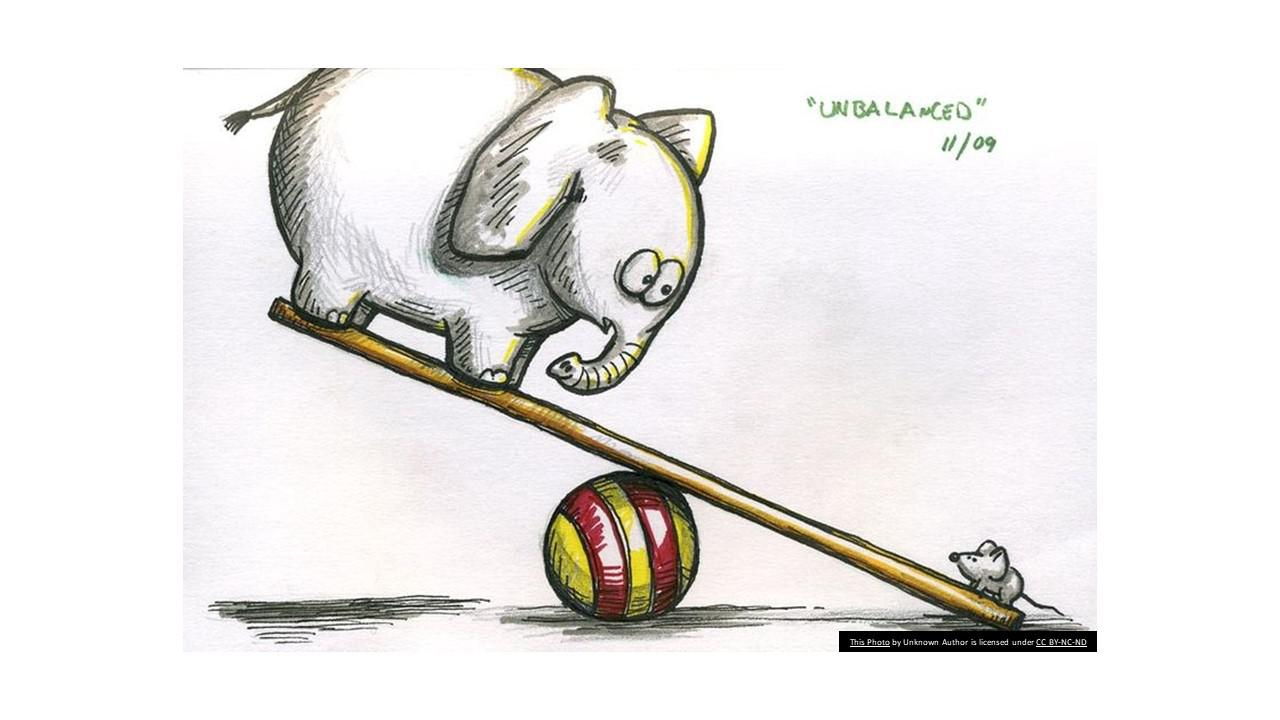

In [1]:
%%capture
%%bash
pip install imbalanced-learn

In [2]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN, SMOTETomek


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Funções Helper

A função a seguir será usada para criar um toy dataset. Ela usa o ``make_classification`` do scikit-learn, mas fixa alguns parâmetros.

In [3]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

A função a seguir será usada para plotar o espaço amostral após a reamostragem para ilustrar as características de um algoritmo.

In [4]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

A função a seguir será usada para plotar a função de decisão de um classificador dados alguns dados.

In [5]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

## Influência da relação de balanceamento

Primeiro ilustraremos a influência da razão de balanceamento em alguns dados de brinquedo usando um classificador SVM linear. Quanto maior for a diferença entre o número de amostras em cada classe, piores serão os resultados da classificação.

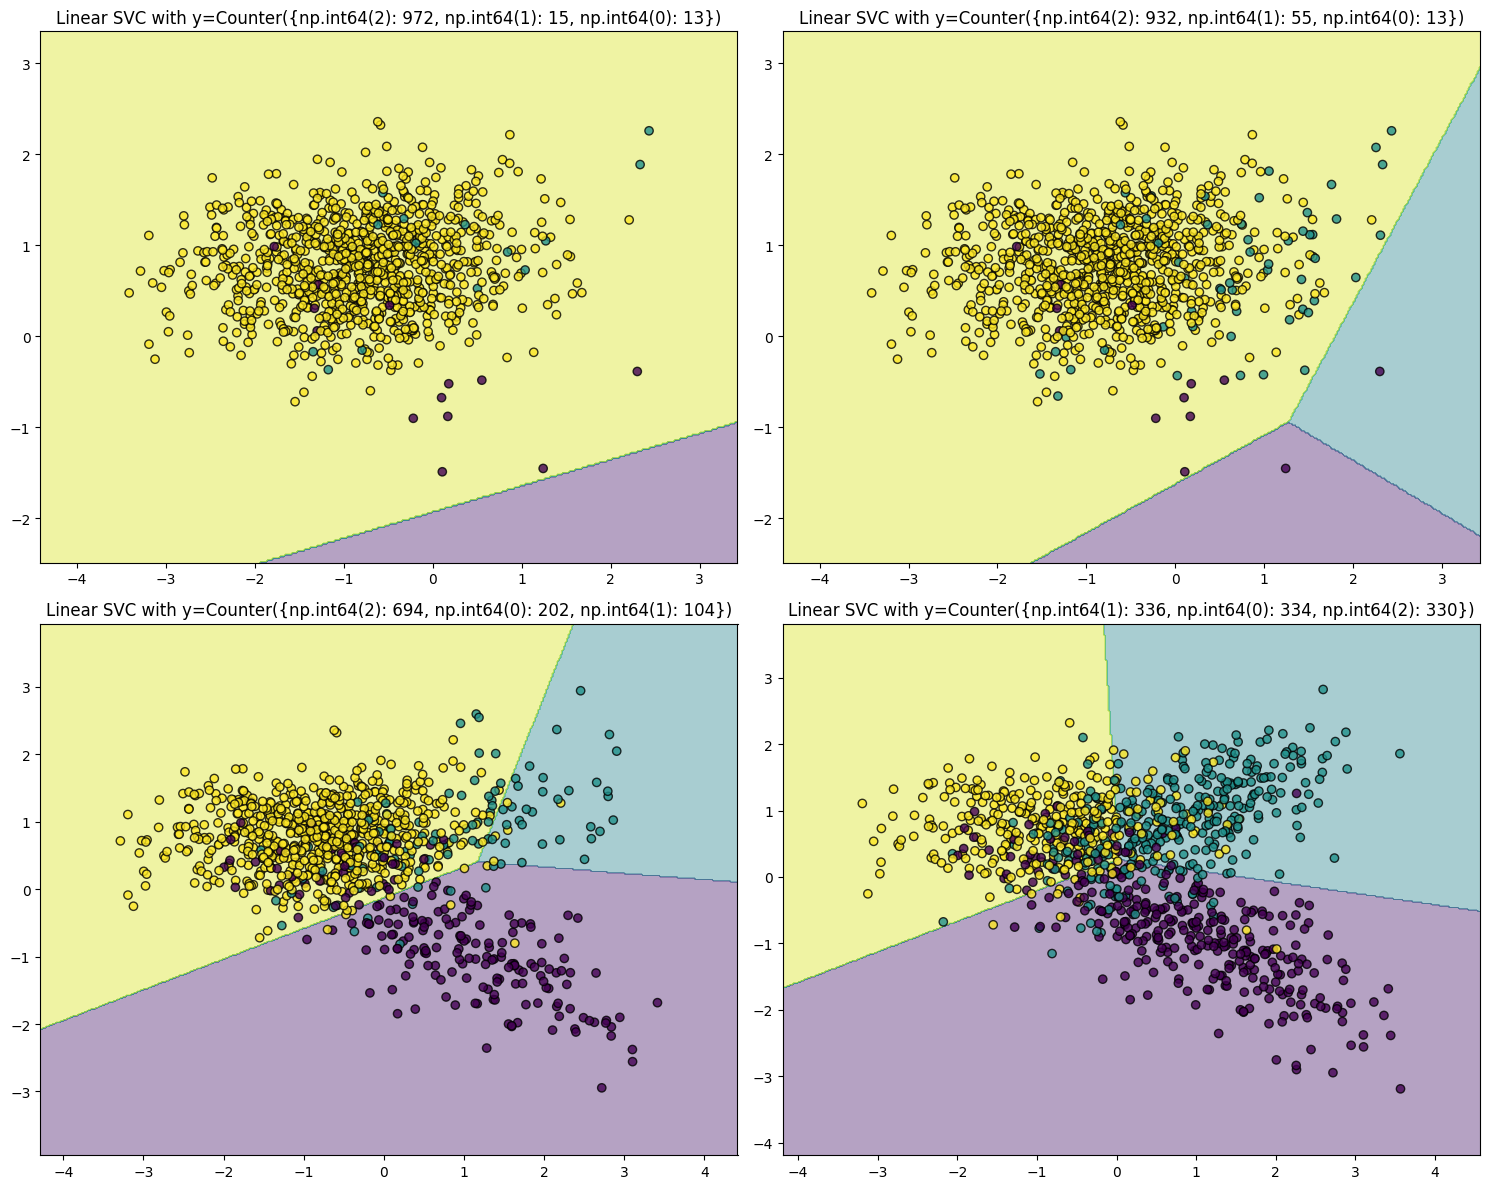

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()

## Subamostragem

### Subamostragem selecionando amostras existentes

Existem dois grupos principais de algoritmos de seleção:

1. os métodos de subamostragem controlados e
2. os métodos de subamostragem de limpeza.

Com os métodos de subamostragem controlados, o número de amostras a serem selecionadas pode ser especificado. ``RandomUnderSampler`` é a maneira mais ingênua de realizar tal seleção selecionando aleatoriamente um determinado número de amostras pela classe alvo.

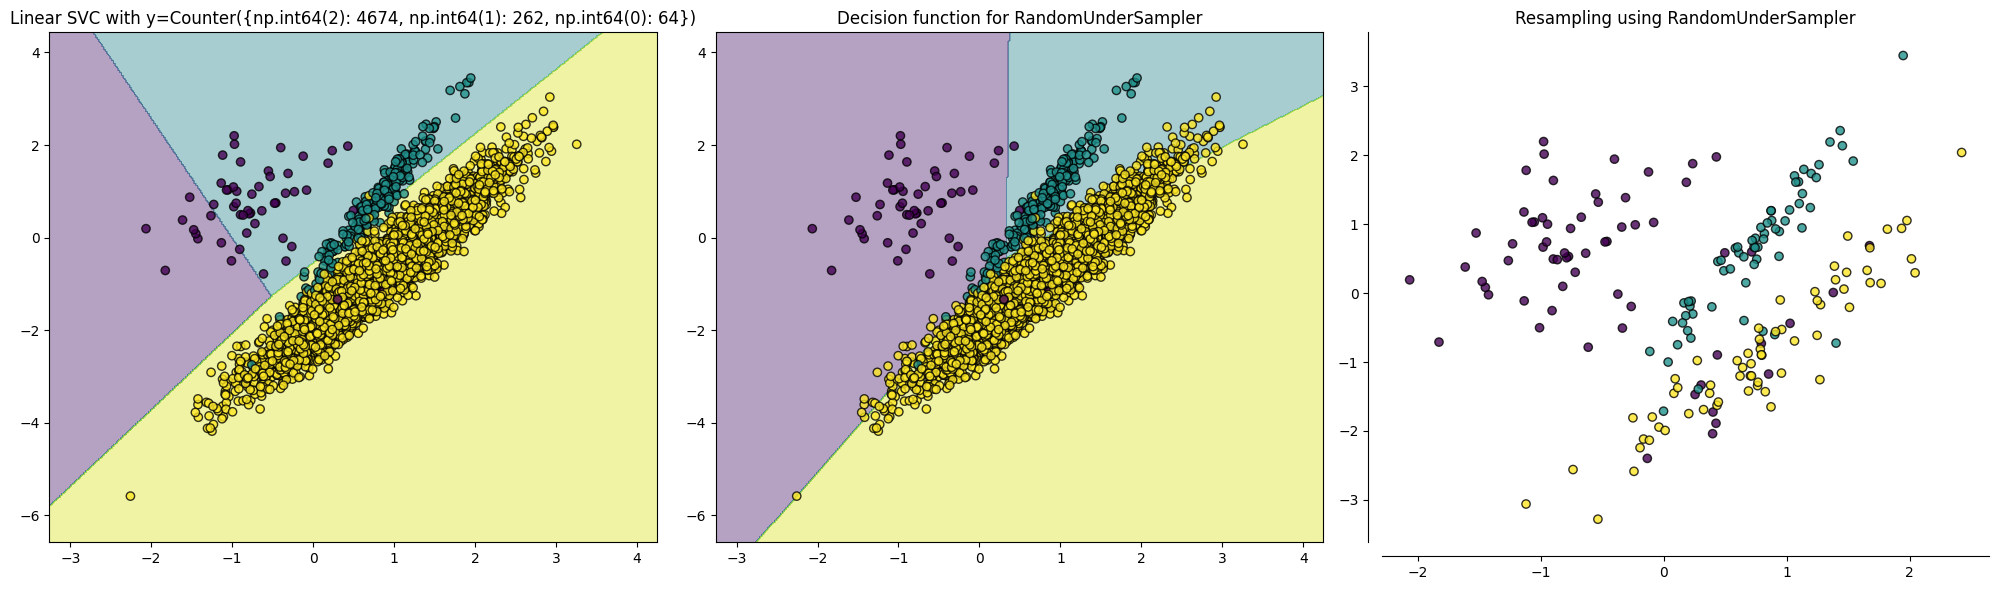

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
X, y = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
sampler = RandomUnderSampler(random_state=0)
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_decision_function(X, y, clf, ax2)
ax2.set_title('Decision function for {}'.format(sampler.__class__.__name__))
plot_resampling(X, y, sampler, ax3)
ax3.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

## Over-sampling

### Sobreamostragem aleatória

A sobreamostragem aleatória com `RandomOverSampler` pode ser usada para repetir algumas amostras e equilibrar o número de amostras entre o conjunto de dados. Pode-se ver que com essa abordagem trivial a decisão de limite já é menos tendenciosa em relação à classe majoritária.

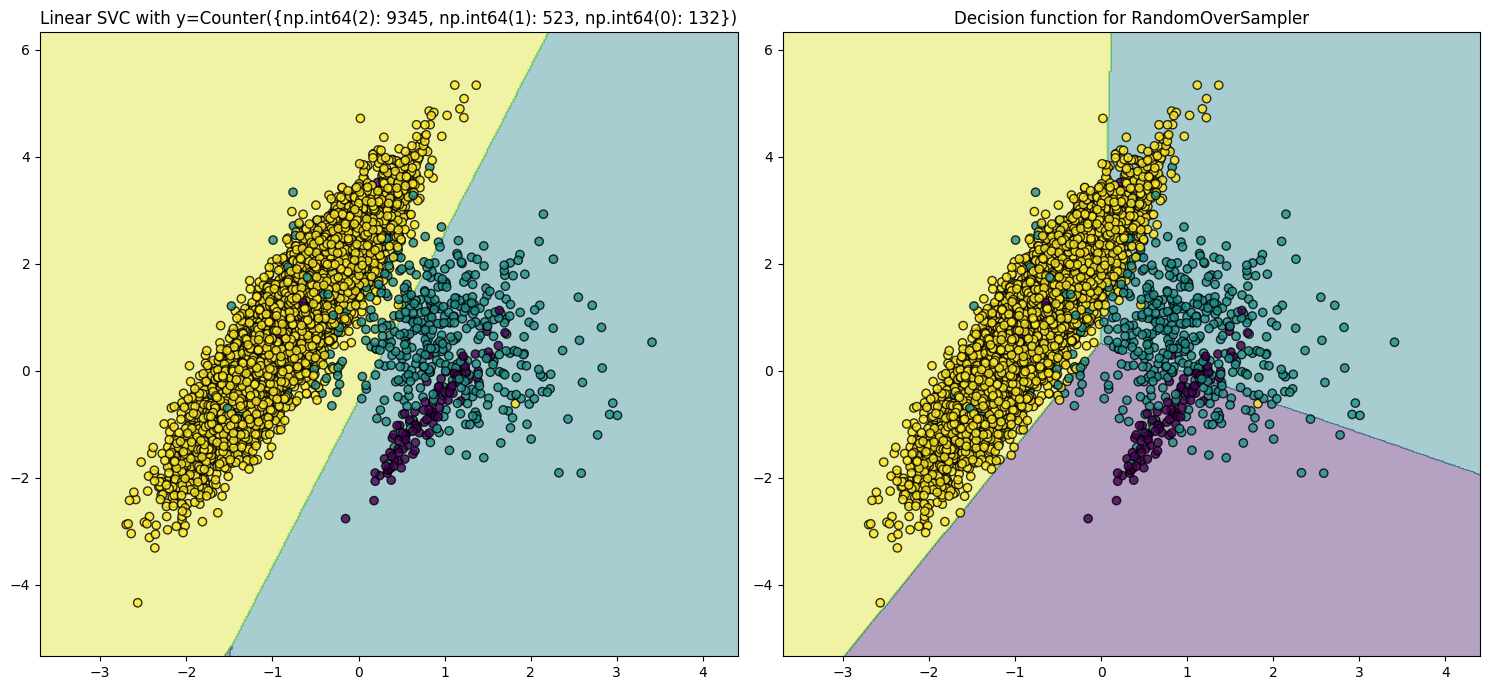

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomOverSampler')
fig.tight_layout()

### Sobreamostragem mais avançada

Em vez de repetir as mesmas amostras durante a sobreamostragem, podemos usar alguma heurística específica, como `SMOTE` ou `ADASYN`.

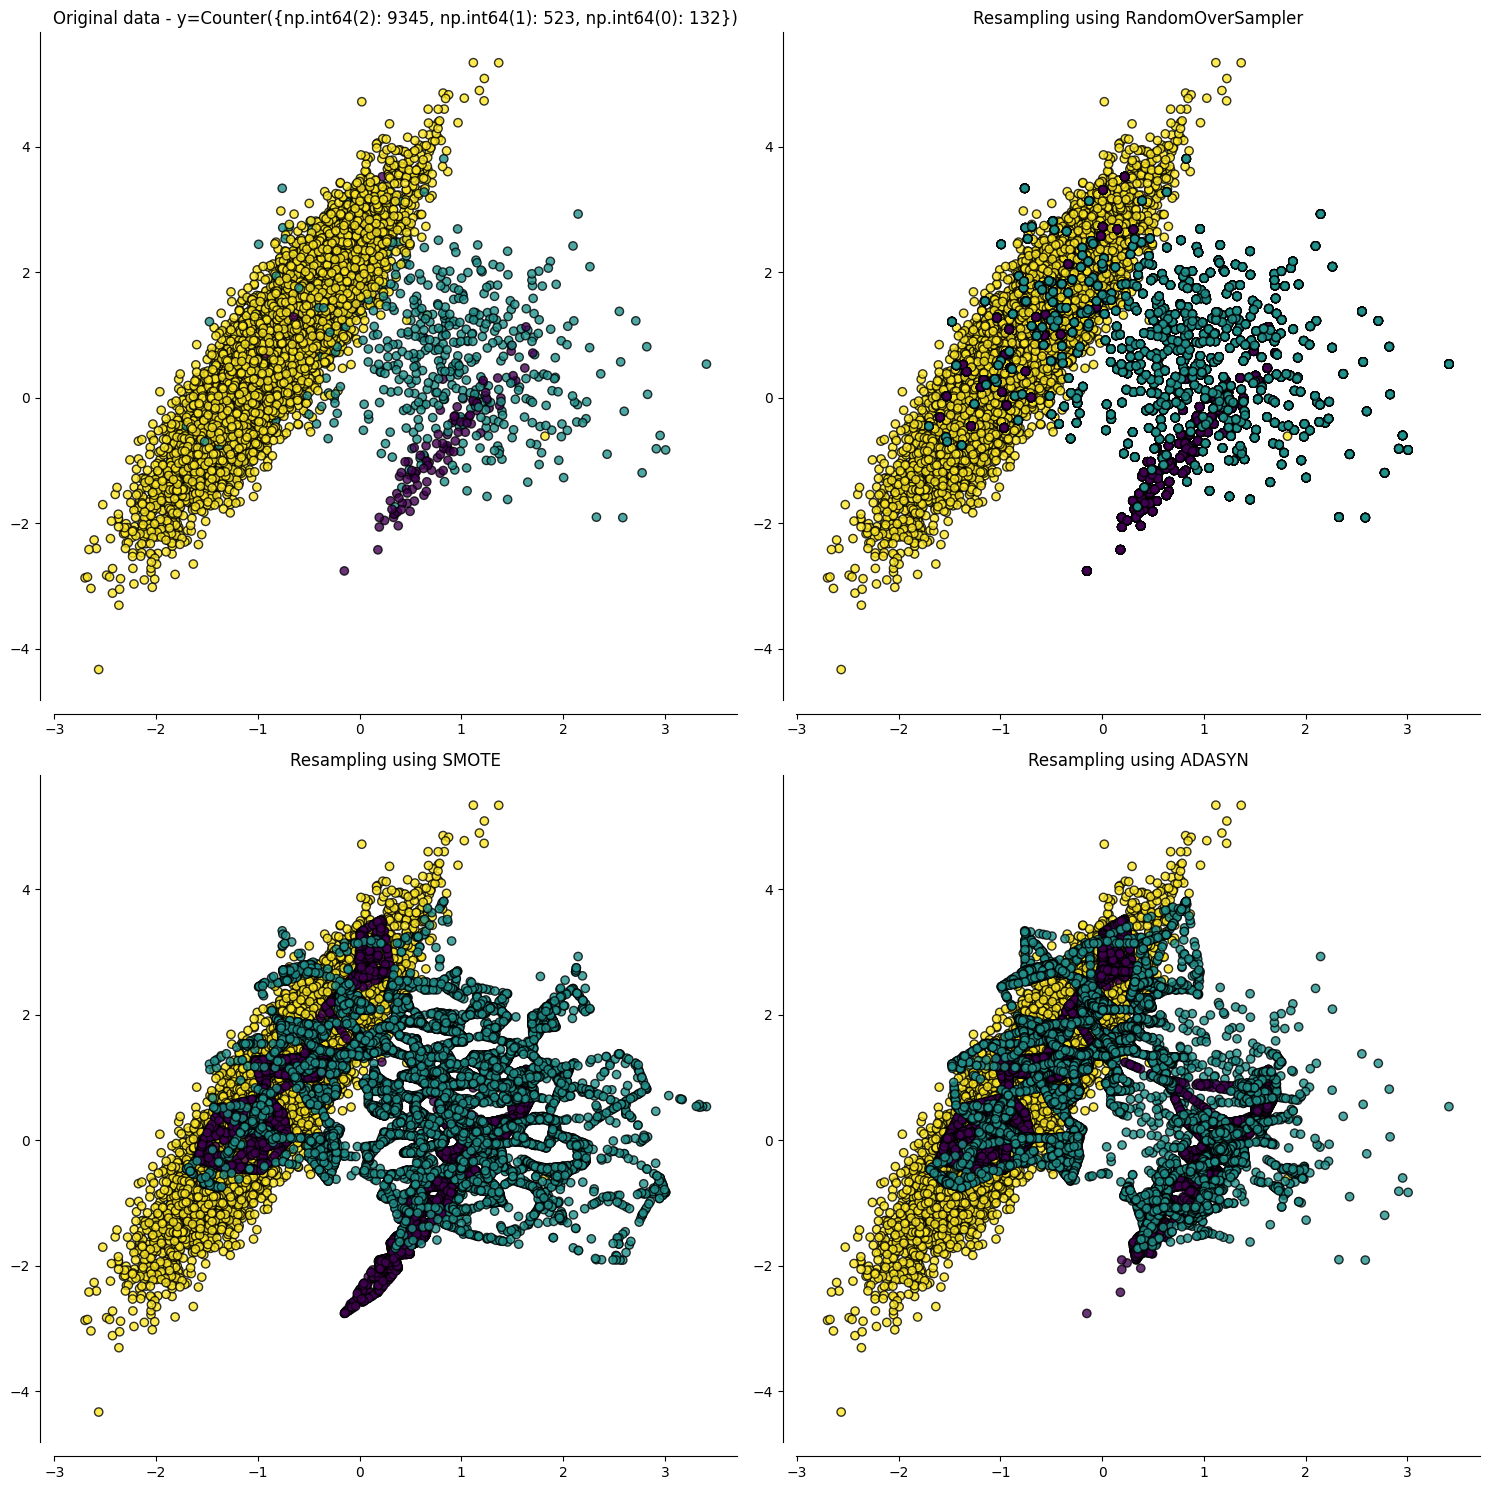

In [13]:
# Make an identity sampler for illustrations
from imblearn.base import BaseSampler
from sklearn.base import BaseEstimator
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE

class FakeSampler(BaseSampler, BaseEstimator):
    _sampling_type = 'bypass'
    _parameter_constraints = {}  # Adicionando para evitar o erro

    def _fit_resample(self, X, y):
        return X, y

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

Ilustração da geração de amostra no algoritmo de sobreamostragem

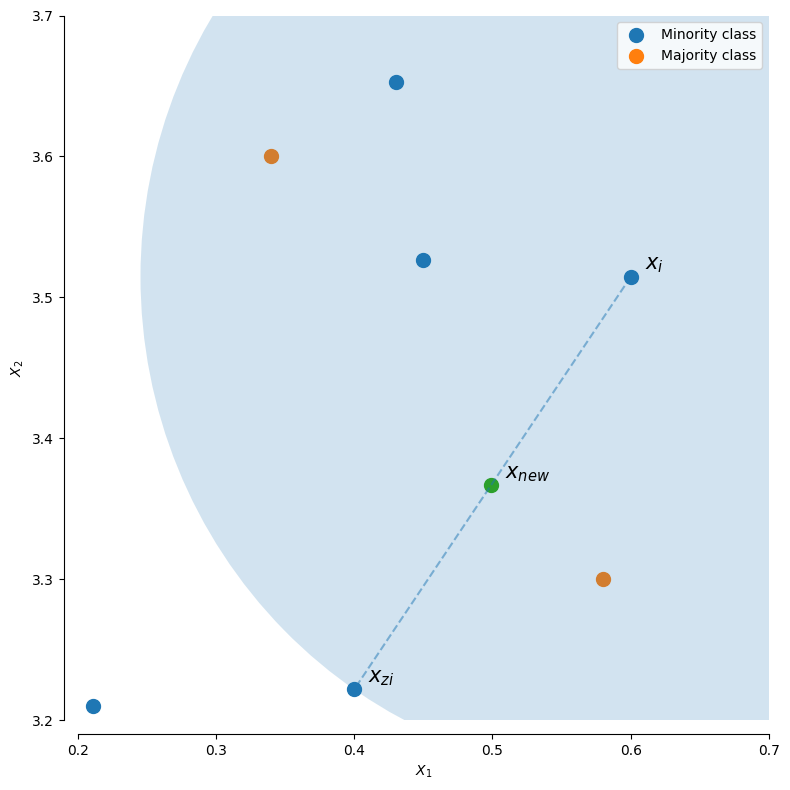

In [14]:
rng = np.random.RandomState(18)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# generate some data points
y = np.array([3.65284, 3.52623, 3.51468, 3.22199, 3.21])
z = np.array([0.43, 0.45, 0.6, 0.4, 0.211])
y_2 = np.array([3.3, 3.6])
z_2 = np.array([0.58, 0.34])

# plot the majority and minority samples
ax.scatter(z, y, label='Minority class', s=100)
ax.scatter(z_2, y_2, label='Majority class', s=100)

idx = rng.randint(len(y), size=2)
annotation = [r'$x_i$', r'$x_{zi}$']

for a, i in zip(annotation, idx):
    ax.annotate(a, (z[i], y[i]),
                xytext=tuple([z[i] + 0.01, y[i] + 0.005]),
                fontsize=15)

# draw the circle in which the new sample will generated
radius = np.sqrt((z[idx[0]] - z[idx[1]]) ** 2 + (y[idx[0]] - y[idx[1]]) ** 2)
circle = plt.Circle((z[idx[0]], y[idx[0]]), radius=radius, alpha=0.2)
ax.add_artist(circle)

# plot the line on which the sample will be generated
ax.plot(z[idx], y[idx], '--', alpha=0.5)

# create and plot the new sample
step = rng.uniform()
y_gen = y[idx[0]] + step * (y[idx[1]] - y[idx[0]])
z_gen = z[idx[0]] + step * (z[idx[1]] - z[idx[0]])

ax.scatter(z_gen, y_gen, s=100)
ax.annotate(r'$x_{new}$', (z_gen, y_gen),
            xytext=tuple([z_gen + 0.01, y_gen + 0.005]),
            fontsize=15)

# make the plot nicer with legend and label
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([0.2, 0.7])
ax.set_ylim([3.2, 3.7])
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.legend()
plt.tight_layout()
plt.show()

## Combine-sampling

Comparação da combinação de algoritmos de over- e under-sampling

Este exemplo mostra o efeito da aplicação de algoritmos de subamostragem após a sobreamostragem SMOTE. Na literatura, o link de Tomek `SMOTETomek` e os vizinhos mais próximos editados `SMOTEENN` são os dois métodos que foram usados ​​e estão disponíveis no balanced-learn.

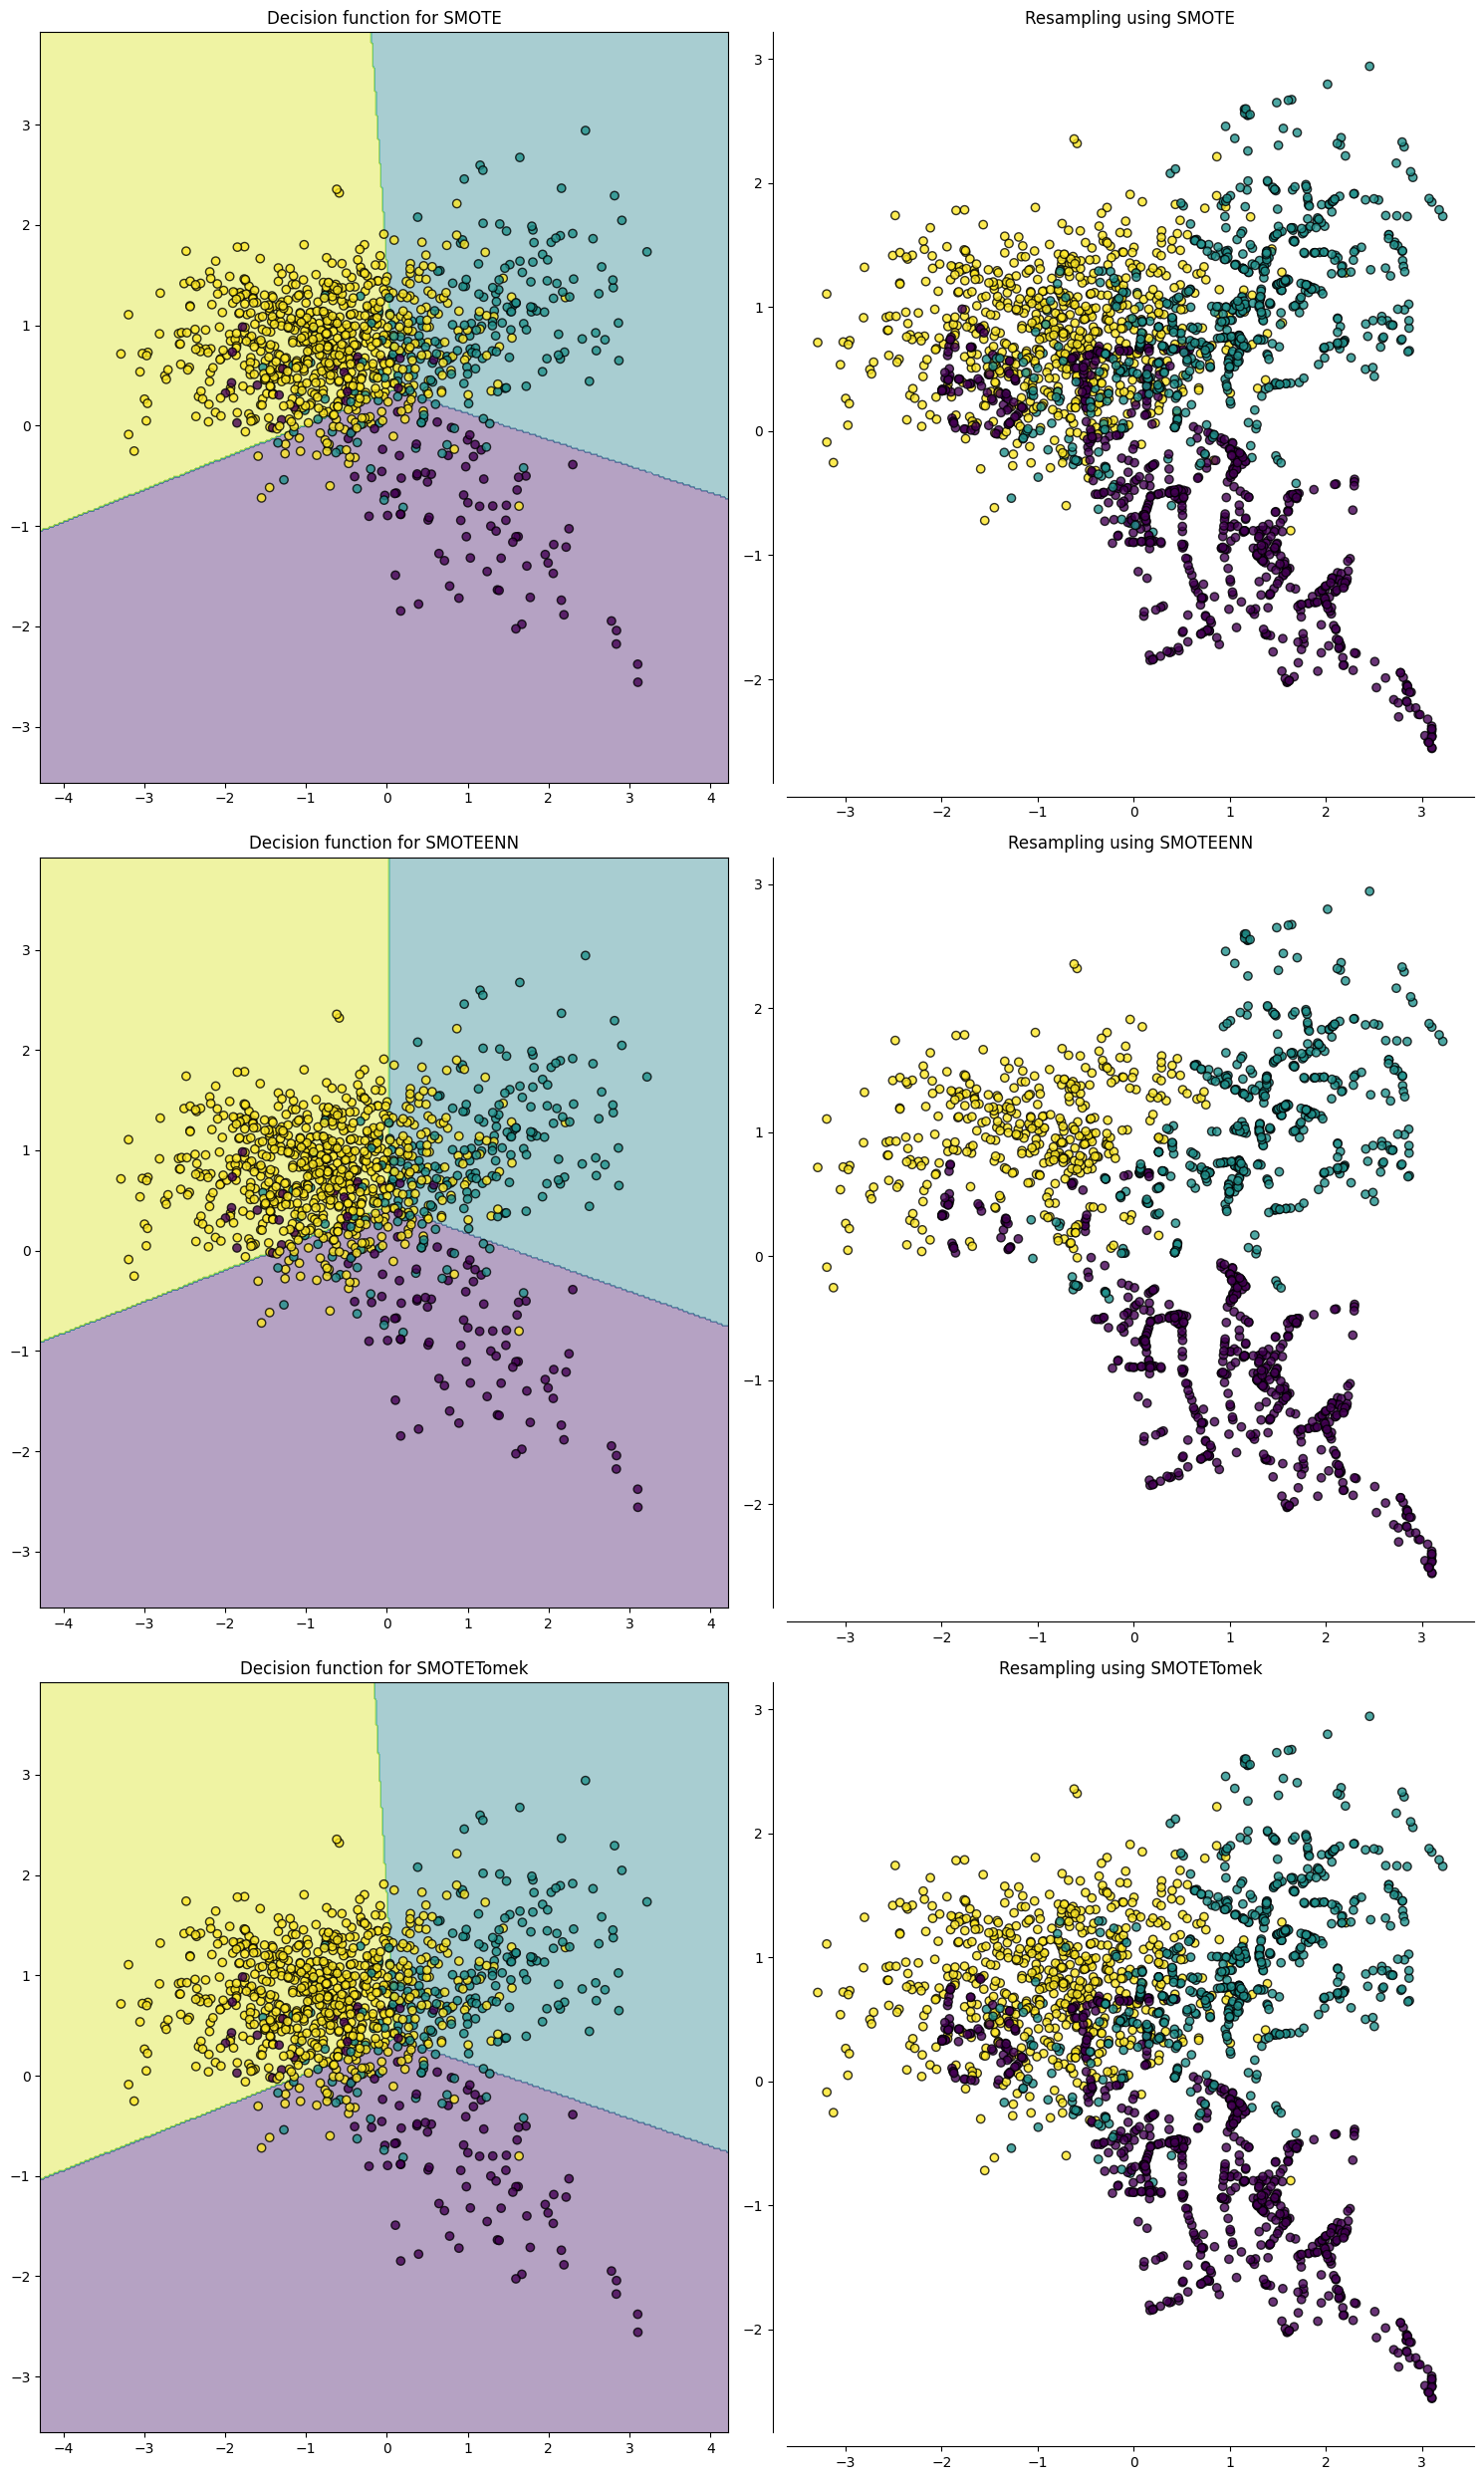

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,
                                                         figsize=(15, 25))
X, y = create_dataset(n_samples=1000, weights=(0.1, 0.2, 0.7))

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6))
for ax, sampler in zip(ax_arr, (
        SMOTE(random_state=0),
        SMOTEENN(random_state=0),
        SMOTETomek(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

plt.show()